In [3]:
import uproot
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LogNorm

In [4]:
import matplotlib.pyplot as plt

In [3]:
infile_name = ('build/HTPC_Sapphire_Th232.root')
infile = uproot.open(infile_name)
event_dir=infile['events']
events = infile['events']["events"]

In [4]:
keys = infile.keys()

print(keys)

['G4VERSION_TAG;1', 'events;1', 'events/nbevents;1', 'events/events;283', 'events/events;282', 'G4RUNTIME;1', 'RANDOM_SEED;1']


In [5]:
primaries = infile["events"]["nbevents"]
primaries.value

250000

In [6]:
def read_root_dir_minimal(fn, treename='events', output_type='df', istart=0, istop=1000):
    '''
    Output types can be 'df' for pandas dataframe or 'array' for numpy array.
    '''
    with uproot.open(fn) as f:
        tree = f[f"{treename}"][f"{treename}"]
        branches = ['nsteps', 'xp', 'yp', 'zp', 'PreStepEnergy', 'etot', 'parentid', 'parenttype', 'xp_pri', 'yp_pri', 'zp_pri', 'ed', 'time']
        data = tree.arrays(branches, filter_name='nsteps', library='np', entry_start = istart, entry_stop=istop)
        
        # Apply selection: NAct > 0
        mask = data['nsteps'] >= 0
        filtered_data = {key: value[mask] for key, value in data.items()}
        
        if output_type == 'df':
            return pd.DataFrame(filtered_data)
        elif output_type == 'array':
            return filtered_data
        else:
            print(f'Warning: output type you specified is {output_type}, not understood, returning numpy array...')
            return filtered_data

In [7]:
row_length = ('nsteps')
scalar_fields = ['etot', 'xp_pri', 'yp_pri', 'zp_pri']
vector_fields = ['xp', 'yp', 'zp', 'PreStepEnergy', 'parentid', 'parenttype', 'ed', 'time']

def flatten_mc_tree(df, row_length=row_length, vector_fields=vector_fields, scalar_fields=scalar_fields):
    flattened_data = []
    for i, row in df.iterrows():
        # Check lengths just in case
        assert row[row_length] == len(row[vector_fields[0]])

        for j in range(row[row_length]):
            new_row = {}
            new_row['event'] = i
            new_row['particle'] = j

            for key in scalar_fields:
                new_row[key] = row[key]

            for key in vector_fields:
                new_row[key] = row[key][j]

            flattened_data.append(new_row)
   
    df_flattend = pd.DataFrame(flattened_data)
    df_flattend.set_index(['event', 'particle',])  # MultiIndex

    return df_flattend

In [8]:
def process_chunk(df):
    xpos = []
    ypos = []
    zpos = []
    multis = []
    escatter=[]
    
    events = np.unique(df['event'])
    for event in events[:]:
        mask = ((df['event']==event) & (df['ed']>0))
        df_event = df[mask]
        xpos.append(np.average(df_event['xp'], weights = df_event['ed']))
        ypos.append(np.average(df_event['yp'], weights = df_event['ed']))
        zpos.append(np.average(df_event['zp'], weights = df_event['ed']))
        escatter.append(np.sum(df_event['ed']))
        multis.append(np.max(df_event['zp'])-np.min(df_event['zp'])>10)
        
    df_scatters = pd.DataFrame({'xpos':xpos,
                                'ypos':ypos,
                                'zpos':zpos,
                                'escatter':escatter,
                                'multis':multis})
    return df_scatters

In [9]:
def df_process_file(infile_name, treename='events', chunksize=1000, bstop=False, istop=-1):
    infile = uproot.open(infile_name)
    tree = infile[f"{treename}"][f"{treename}"]
    primaries = tree.arrays('etot')
    primaries = len(primaries)
    df_scatters =[]
    print(np.ceil(primaries/chunksize))
    for i_chunk in tqdm(range(int(np.ceil(primaries/chunksize)))):
        if bstop and (chunksize*i_chunk)>istop:
            break
        df_raw = read_root_dir_minimal(infile_name, treename, istart=chunksize*i_chunk, istop=chunksize*(i_chunk+1))
        df_flat = flatten_mc_tree(df_raw)
        df_flat = df_flat[df_flat['etot']>0]
        df_scatters.append(process_chunk(df_flat))
    df_scatters = pd.concat(df_scatters)
    return df_scatters

In [12]:
test_df = df_process_file(infile_name, treename='events', chunksize =100, bstop=True, istop =10000)

2491.0


  4%|▍         | 101/2491 [16:41<6:34:48,  9.91s/it]


In [ ]:
test_df2 = df_process_file(infile_name, treename='events', chunksize =100, bstop=True, istop =50000)

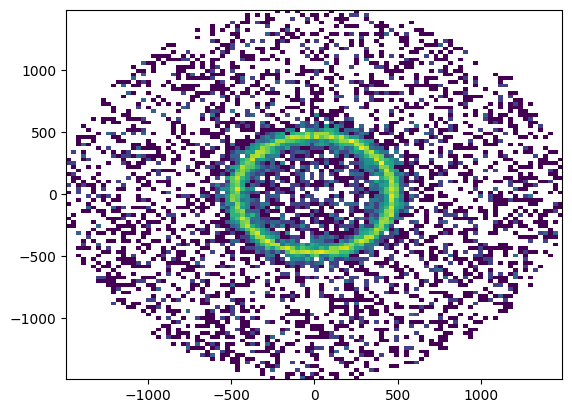

In [14]:
plt.hist2d(test_df['xpos'], test_df['ypos'],  bins=[100, 100], norm=LogNorm())
plt.show()

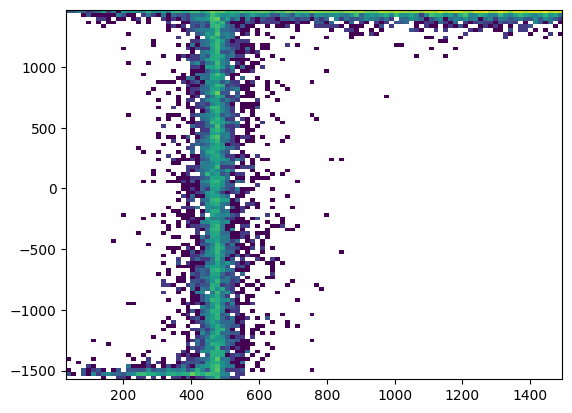

In [15]:
plt.hist2d(np.sqrt(test_df['xpos']**2+test_df['ypos']**2), test_df['zpos'],  bins=[100, 100], norm=LogNorm())
plt.show()

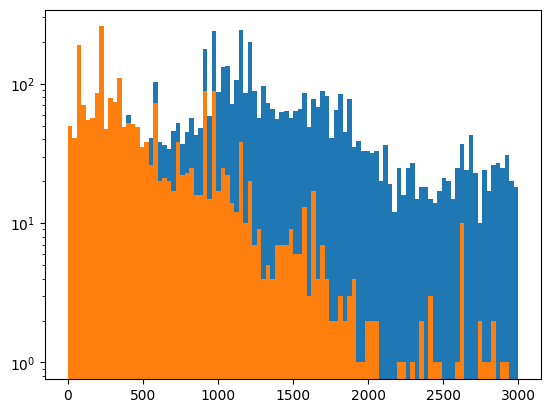

In [22]:
mask = (test_df['multis']==True)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Multiscatter')
mask = (test_df['multis']==False)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Singlescatter')
plt.yscale('log')
plt.show()

### Processed Background Files

In [69]:
test_df = np.load('analysis/test.npy', allow_pickle=True)
test_df = pd.DataFrame(test_df, columns=['xpos', 'ypos', 'zpos', 'escatter', 'multis'])

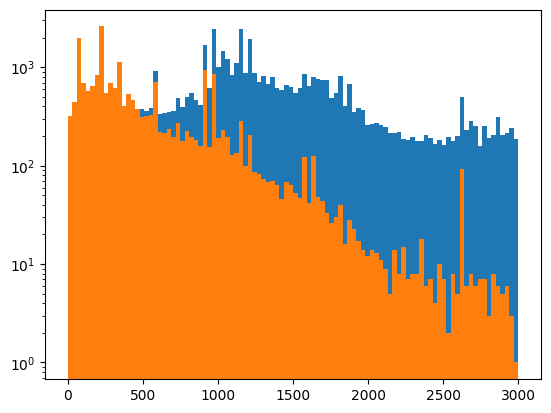

In [70]:
mask = (test_df['multis']==True)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Multiscatter')
mask = (test_df['multis']==False)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Singlescatter')
plt.yscale('log')
plt.show()

In [72]:
def energy_res(energy, a_res, b_res):
    resolution = a_res*np.sqrt(energy.values)+b_res*10**-3*energy
    e_smeared = np.random.normal(energy,resolution)
    return e_smeared

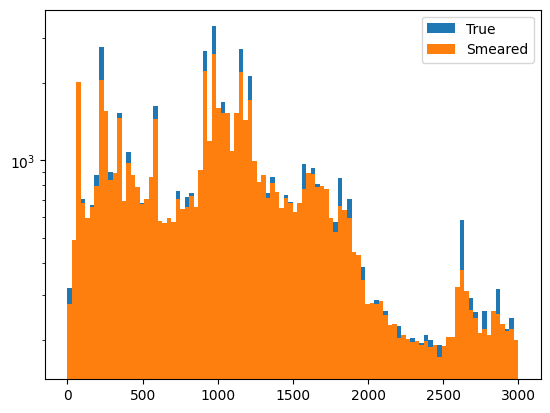

In [73]:
plt.hist(test_df['escatter'], bins =np.linspace(0, 3000, 101), label = 'True')
plt.hist(energy_res(test_df['escatter'].astype(float), 0.317, 1.7), bins =np.linspace(0, 3000, 101), label = 'Smeared')
plt.legend()
plt.yscale('log')
plt.show()